In [ ]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"


Mounted at /content/drive


In [ ]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/Colab\ Notebooks/COVID-19_Radiography_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
 

In [4]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [5]:
# Extracting all filenames iteratively
base_path = '/content/COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']


In [6]:
# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
   

In [7]:
image_folder

'/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images'

In [12]:
 file_names = os.listdir(image_folder)
 full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
 fnames.append(full_path)


In [9]:
print('number of images for each category:', [len(f) for f in fnames])


number of images for each category: [1345]


In [10]:
print(fnames[0:2]) #examples of file names

[['/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-56.png', '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-623.png', '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1013.png', '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-851.png', '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-51.png', '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-831.png', '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1172.png', '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1112.png', '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-231.png', '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1208.png', '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-357.png', '/content/COVID-19_Radiograp

In [13]:
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [14]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [ ]:
img

NameError: ignored

In [15]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [ ]:
len(image_filepaths)

4032

In [ ]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [ ]:
len(fnames[2])

1344

## **Visualize images that demonstrate when x-rays demonstrate Covid Positivity and when they do not**

In [22]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


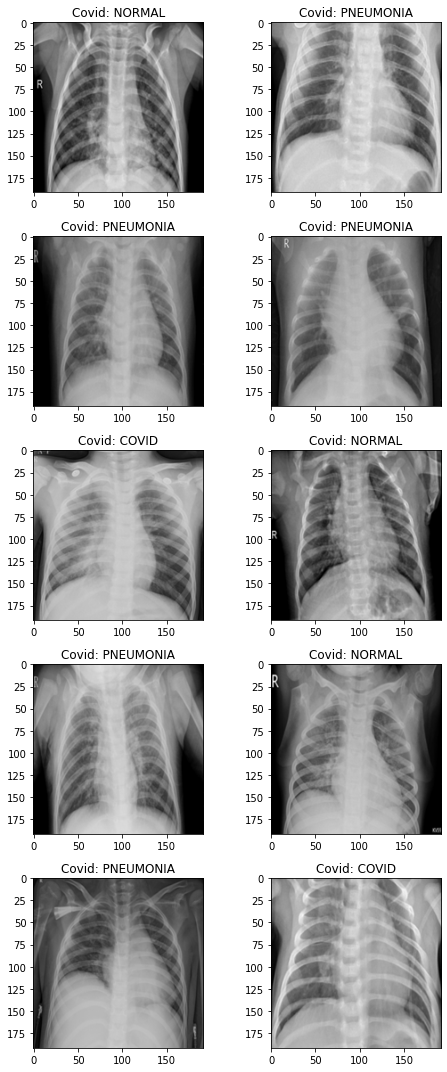

In [23]:
# Visualize images...
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(5, 2)
fig.set_size_inches(7, 15)
for i in range(5):
    for j in range (2):
        l = np.random.randint(0, len(y_labels))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Covid: ' + y_labels[l])
        
plt.tight_layout()

This visualization tells us when a person has covid, pneumonia or is completely normal. 

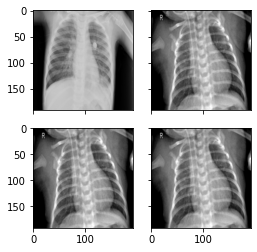

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[1][1])
im4 =preprocessor(fnames[1][1])

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

In [35]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [36]:
X_train.shape,y_train.shape

((2741, 192, 192, 3), (2741, 3))

In [ ]:
y

In [37]:
y_train

,COVID,NORMAL,PNEUMONIA
2120,0,1,0
179,1,0,0
110,1,0,0
3423,0,0,1
455,1,0,0
...,...,...,...
3587,0,0,1
2139,0,1,0
612,1,0,0
1775,0,1,0


In [81]:

# Let's build a convnet model...
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
import tensorflow as tf
with tf.device('/device:GPU:0'): # "/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
                                 
        model = Sequential()
        model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=[192, 192, 3]))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Flatten())
        model.add(Dense(100, activation='relu')) # One fully-connected layer of 100 neurons.

        model.add(Dense(3, activation='softmax')) # Last fully-connected layer of 5 outputs (5 categories).

        # Compile model...
        model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        # Fitting the NN to the Training set...
        model.fit(X_train, y_train,
                          epochs=3, verbose=1, validation_data=(X_test, y_test))

Epoch 1/3
 1/86 [..............................] - ETA: 3:26 - loss: 1.1025 - accuracy: 0.3438

KeyboardInterrupt: ignored

In [ ]:
# format y_pred as labels 
y_pred = model.predict(X_test).argmax(axis=1)
predicted_labels = [y_test.columns[i] for i in y_pred]
predicted_labels[0:5]

In [ ]:
plt.show (y_pred)

## **Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.**

The Dataset contains 3487 Chest X-ray images, which include 423 COVID-19, 1485 viral pneumonia, and 1579 normal X-ray images. If we can develop a predictive model using this dataset, we can use the model to determine if a person has covid/ pneumonia depending on the images. If a model can be trained to recognize when a person has covid or pneumonia, when new data is used in the model, it can predict if the x-ray image resembles a covid, pneumonia or normal image. This is very beneficial for doctors, patients and people in the healthcare industry as more people can be diagnosed and it reduces the load on doctors to go through every single X-ray. Results are obtained faster and treatment can begin almost immediately for a lot of people. A model sorting through several images in a small span of time is very helpful as multiple people's results can be obtained rapidly and reliably.

In [82]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [83]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [84]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

## **Model 1** 

In [85]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

KeyboardInterrupt: ignored

In [ ]:
model.save("model1.h5", save_format="h5")

In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
# Restart session Runtime > Restart runtime

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model1.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fcddd54f3a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 120s 3s/step


In [62]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): .
Provide any useful notes about your model (optional): .

Your model has been submitted as model version 430

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

Model 1 is a sequential model . It runs for 1 epoch,  The accuracy for this model is 33.31%, the f-1 score is 16.66% and the precision is 11.10%.


## **Model 2 - Inception V3, 1 epoch**

In [78]:
IMG_SHAPE = (192, 192, 3)

In [ ]:
base_model = InceptionV3(input_shape= IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary()

In [ ]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

In [52]:
# example of loading the Inception model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

In [ ]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 1, verbose=1,validation_split=.2)

69/69 [==============================] - 289s 4s/step - loss: 1.3078 - acc: 0.3180 - val_loss: 1.2168 - val_acc: 0.3042


In [ ]:
# example of loading the Inception model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

In [ ]:
len(base_model.trainable_variables) #188 trainable layers


188

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=10

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model.layers)-freeze_layers_after)

Number of layers in the base model:  311
Number of layers frozen in the base model:  301


In [ ]:
len(base_model.trainable_variables)

6

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

In [ ]:
# Fit Inception model with some unfrozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 1, verbose=1,validation_split=.2)

69/69 [==============================] - 851s 12s/step - loss: 1.2639 - acc: 0.3221 - val_loss: 1.2664 - val_acc: 0.3206


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

41/41 [==============================] - 125s 3s/step


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): .
Provide any useful notes about your model (optional): .

Your model has been submitted as model version 432

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


model 2 - Inception V 3 

The model has one GAP layer and output layer added to the frozen layers of the original model , 311 layers in base model, 301 layers frozen in base model. It is fitted to run for 1 epoch. Another GAP layer and output layer are added. The accuracy for this model is 31.76%, the f-1 score is 26.55% and the precision is 29.33%.

## **MODEL 3- vgg 16 1 hidden layer 112 neurons**

In [68]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3

In [ ]:
base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

In [ ]:
# Next step: Freeze the weights of the VGG16 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

In [ ]:
# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(112, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

# define new model
model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model.summary()

In [72]:
# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 1, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

2192/2192 [==============================] - ETA: 0s - loss: 1.1275 - acc: 0.3463
Epoch 00001: val_acc improved from -inf to 0.34062, saving model to best_model.h5
2192/2192 [==============================] - 1023s 466ms/step - loss: 1.1275 - acc: 0.3463 - val_loss: 1.1005 - val_acc: 0.3406 - lr: 0.0100


In [73]:
import numpy as np
#Extract learning rate callback
learning_rates=model.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.01]
1


In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 3)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

41/41 [==============================] - 651s 16s/step


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): .
Provide any useful notes about your model (optional): .

Your model has been submitted as model version 434

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


This model has 1 hidden layer with 112 neurons. It runs for one epoch
The accuracy for this model is 33.31%, the f-1 score is 16.55% and the precision is 11.10%. Its learning rate is 0.01


The best model out of the ones I have tried here before discussion with my team is Model 2 which is a transfer learning model - Inception V3.

The model has one GAP layer and output layer added to the frozen layers of the original model , 311 layers in base model, 301 layers frozen in base model. It is fitted to run for 1 epoch. Another GAP layer and output layer are added. The accuracy for this model is 31.76%, the f-1 score is 26.55% and the precision is 29.33%. 

## **Model 4- ResNet50 1 layer**

In [ ]:
# example of loading a version of the Resnet Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

In [ ]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input


# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()


In [ ]:
# Fit Resnet model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 1, verbose=1,validation_split=.2)

69/69 [==============================] - 418s 6s/step - loss: 1.4671 - acc: 0.3248 - val_loss: 1.7108 - val_acc: 0.3206


In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 3)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

41/41 [==============================] - 200s 5s/step


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): .
Provide any useful notes about your model (optional): .

Your model has been submitted as model version 435

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


The model has one GAP layer and output layer added to the frozen layers of the original model and is fit to run for 1 epoch.
The accuracy for this model is 33.31%, the f-1 score is 16.66% and the precision is 11.10%.


##**Model 5- Inception- 5 Epochs**

In [ ]:
IMG_SHAPE = (192, 192, 3)

In [ ]:
base_model = InceptionV3(input_shape= IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary()

In [ ]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

In [ ]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 5, verbose=1,validation_split=.2)

Epoch 1/5
69/69 [==============================] - 272s 4s/step - loss: 1.2699 - acc: 0.3171 - val_loss: 1.1770 - val_acc: 0.3224
Epoch 2/5
69/69 [==============================] - 261s 4s/step - loss: 1.2044 - acc: 0.3394 - val_loss: 1.2234 - val_acc: 0.3133
Epoch 3/5
69/69 [==============================] - 265s 4s/step - loss: 1.1917 - acc: 0.3568 - val_loss: 1.3317 - val_acc: 0.2787
Epoch 4/5
69/69 [==============================] - 257s 4s/step - loss: 1.2216 - acc: 0.3572 - val_loss: 1.2289 - val_acc: 0.2769
Epoch 5/5
69/69 [==============================] - 257s 4s/step - loss: 1.1474 - acc: 0.3668 - val_loss: 1.2658 - val_acc: 0.2805


In [ ]:
# example of loading the Inception model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

In [ ]:
len(base_model.trainable_variables) #188 trainable layers

188

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=10

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model.layers)-freeze_layers_after)

Number of layers in the base model:  311
Number of layers frozen in the base model:  301


In [ ]:
len(base_model.trainable_variables)

6

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

In [ ]:
# Fit Inception model with some unfrozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 5, verbose=1,validation_split=.2)

Epoch 1/5
35/69 [==============>...............] - ETA: 6:13 - loss: 1.2773 - acc: 0.3223

In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

Model 5- InceptionV3- 5 epochs

The model has one GAP layer and output layer added to the frozen layers of the original model , 311 layers in base model, 301 layers frozen in base model. It is fitted to run for 5 epochs. Another GAP layer and output layer are added. It is fitted again to run for 5 epochs. The accuracy for this model is 28.43 %, the f-1 score is 21.17% and the precision is 28.44%.


## **Model 6 - Vgg 16 2 layers**

In [ ]:
base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

In [ ]:
# Next step: Freeze the weights of the VGG16 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

In [ ]:
# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(112, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

# define new model
model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model.summary()

In [97]:
# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 1, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

2192/2192 [==============================] - ETA: 0s - loss: 1.1322 - acc: 0.3380
Epoch 00001: val_acc improved from -inf to 0.34062, saving model to best_model.h5
2192/2192 [==============================] - 1018s 464ms/step - loss: 1.1322 - acc: 0.3380 - val_loss: 1.1008 - val_acc: 0.3406 - lr: 0.0100


In [98]:
import numpy as np
#Extract learning rate callback
learning_rates=model.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.01]
1


In [99]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 3)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

41/41 [==============================] - 435s 11s/step


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): .
Provide any useful notes about your model (optional): .

Your model has been submitted as model version 437

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


Model 6 - Vgg 16 with 2 dense layers with 112 neurons each for  1 epoch . 

 The accuracy for this model is 13.38%, the f-1 score is 16.69% and the precision is 11.13%.
Its learning rate is 0.01

## **Data Augmentation**

In [16]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [41]:
augmented_images = [X_train[0][0][0] for i in range(5)]

In [42]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
 fig, ax = plt.subplots(5, 2)
fig.set_size_inches(7, 15)
for i in range(5):
    for j in range (2):
        l = np.random.randint(0, len(y_labels))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Covid: ' + y_labels[l])
        
plt.tight_layout()


<Figure size 432x288 with 0 Axes>

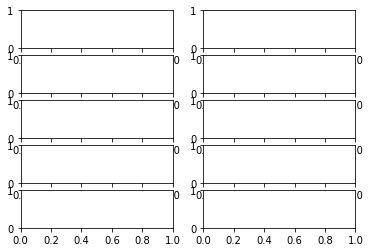

In [43]:
plotImages(augmented_images) 

After rotation

In [44]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [45]:
augmented_images = [X_train[0][0][0] for i in range(5)]

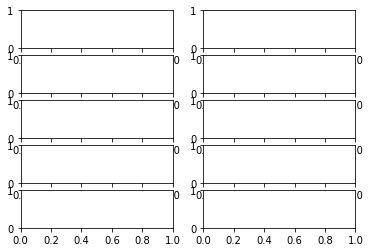

In [46]:
plotImages(augmented_images)

Putting it together

In [47]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

## **Run a model- Inception V3**

In [48]:
IMG_SHAPE = (192, 192, 3)

In [ ]:
base_model = InceptionV3(input_shape= IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary()

In [ ]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

In [54]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 1, verbose=1,validation_split=.2)

69/69 [==============================] - 198s 3s/step - loss: 1.2879 - acc: 0.3303 - val_loss: 1.3063 - val_acc: 0.3297


In [ ]:
# example of loading the Inception model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

In [56]:
len(base_model.trainable_variables) #188 trainable layers

188

In [57]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=10

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model.layers)-freeze_layers_after)

Number of layers in the base model:  311
Number of layers frozen in the base model:  301


In [58]:
len(base_model.trainable_variables)

6

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

In [60]:
# Fit Inception model with some unfrozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 5, verbose=1,validation_split=.2)

Epoch 1/5
69/69 [==============================] - 559s 8s/step - loss: 1.2783 - acc: 0.3248 - val_loss: 1.3532 - val_acc: 0.3461
Epoch 2/5
69/69 [==============================] - 510s 7s/step - loss: 1.1770 - acc: 0.3467 - val_loss: 1.1906 - val_acc: 0.3260
Epoch 3/5
69/69 [==============================] - 542s 8s/step - loss: 1.2050 - acc: 0.3385 - val_loss: 1.3362 - val_acc: 0.3024
Epoch 4/5
69/69 [==============================] - 503s 7s/step - loss: 1.1797 - acc: 0.3253 - val_loss: 1.2254 - val_acc: 0.3315
Epoch 5/5
69/69 [==============================] - 507s 7s/step - loss: 1.1386 - acc: 0.3485 - val_loss: 1.1696 - val_acc: 0.2678


In [66]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

41/41 [==============================] - 99s 2s/step


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): .
Provide any useful notes about your model (optional): .

Your model has been submitted as model version 439

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


Thia is a transfer learning model - Inception V3.

 The model has one GAP layer and output layer added to the frozen layers of the original model , 311 layers in base model, 301 layers frozen in base model. It is fitted to run for 1 epoch. Another GAP layer and output layer are added. It is now fit to run for 5 epochs.The accuracy for this model is 131.22, the f-1 score is 27.63% and the precision is 30.23%.

In [67]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

The best models out of the many I have tried here before and after discussion with my team are the following models:

1) Model 2 which is a transfer learning model - Inception V3. 

The model has one GAP layer and output layer added to the frozen layers of the original model , 311 layers in base model, 301 layers frozen in base model. It is fitted to run for 1 epoch. Another GAP layer and output layer are added.
 The accuracy for this model is 31.76%, the f-1 score is 26.55% and the precision is 29.33%.


2) Model 5 which is a transfer learning model- Inception V3. 

The model has one GAP layer and output layer added to the frozen layers of the original model , 311 layers in base model, 301 layers frozen in base model. It is fitted to run for 5 epochs. Another GAP layer and output layer are added. It is fitted again to run for 5 epochs. The accuracy for this model is 28.43 %, the f-1 score is 21.17% and the precision is 28.44%.


3) Model 6 is slightly better than the rest of the other models but very marginally despite running for 5 epochs. It is however a vgg 16 model with 2 dense layers with 112 neurons in each.The accuracy for this model is 13.38%, the f-1 score is 16.69% and the precision is 11.13%. Its learning rate is 0.01


4) The last model after augmentation is the best.It is a transfer learning model - Inception V3. The model has one GAP layer and output layer added to the frozen layers of the original model , 311 layers in base model, 301 layers frozen in base model. It is fitted to run for 1 epoch. Another GAP layer and output layer are added. It is now fit to run for 5 epochs.The accuracy for this model is 31.22%, the f-1 score is 27.63% and the precision is 30.23%.

I tried using the sequential model(Model 1), the RestNet Model (Model 4) and the vgg 16 model with one dense layer and 112 neurons but their results were not great
 